In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import StationaryGaussianProcess

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as np
import yaml
from led_array.tf_util import prepare_test_dataset
import tensorflow.keras as tfk

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-12-08 09:11:49.662193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Opening BSCCM
Opened BSCCM


array([1.32430963, 2.36331186, 2.52155439])

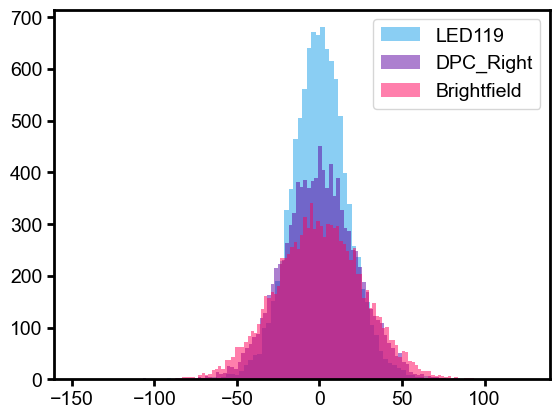

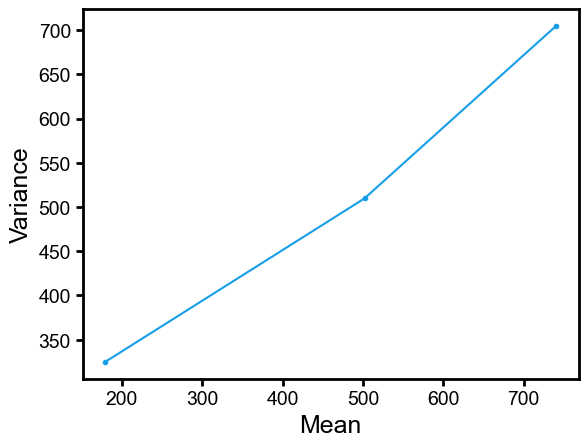

In [13]:
indices = bsccm.get_indices(batch=1)[:40]

def get_corner_patches(image, mean_sub=True):
    top_left = image[:8, :8]
    top_right = image[:8, -8:]
    bottom_left = image[-8:, :8]
    bottom_right = image[-8:, -8:]
    all = np.stack([top_left.flatten(), top_right.flatten(), bottom_left.flatten(), bottom_right.flatten()])
    # mean subtract
    if mean_sub:
        all = all - np.mean(all, axis=1, keepdims=True)
    return all.ravel()

fig, ax = plt.subplots()
stds = []
means = []
for channel in ['LED119', 'DPC_Right', 'Brightfield']:
    images = load_bsccm_images(bsccm, channel, indices=indices)
    pixels = np.array([get_corner_patches(image, mean_sub=True) for image in images])
    unnormed_pixels = np.array([get_corner_patches(image, mean_sub=False) for image in images])
    _ = ax.hist(pixels.ravel(), bins=100, alpha=0.5, label=channel)
    stds.append(np.std(pixels))
    means.append(np.mean(unnormed_pixels))
ax.legend()
means = np.array(means)
vars = np.array(stds) ** 2

fig, ax = plt.subplots()
ax.plot(means / 2.4, vars, '.-')
ax.set_xlabel('Mean')
ax.set_ylabel('Variance')

means / vars